Данный ноутбук служит опорой для выбора модели, которая будет анализировать эмоционал писем

Для анализа будут использоваться следующие модели:

- GigaChatLite. Русская модель, которая разработана компанией "Сбер". Является одним из лучших бюджетных вариантов, которые могут работать по API
- Qwen3-235B-A22B. Модель, выпущенная компанией "Alibaba" в прошлом месяце. Неплохо показала себя на арене open-source моделей
- DeepSeekV3. Одна из лучших моделей по бенчмаркам от одноименной компании
- Gemini-2.0. Доступная бесплатная модель Google для генерации текста

# Импорт датасета

In [1]:
import pandas as pd

letters = pd.read_pickle('../data/letters.pkl').head(25)

In [2]:
letters.head()

,id,date,author,text,url,sender,recipient,destination
0,3e9e6d51be6409ba,1945-03-19 00:00:00,Зубова Василия Михайловича,19.03.45 \t\t\t\t\t\t...,https://pismapobedy.ru/letters#letter-3e9e6d51...,Госпиталь в Эривани,жене Наталии Григорьевне Пруссовой,Москва
1,a058a701dbcdaf76,1945-01-15 00:00:00,Шкиранда И.,Письмо 15 января 1945 год.\n\n\tЗдравствуйте д...,https://pismapobedy.ru/letters#letter-a058a701...,п/п 71799-А,Шкиранду Тихону Иванов.,"БССР, Витебская область, г. Лепель, Лепельский..."
2,c1388d2dd007429c,1970-01-01 00:00:00,unknown,Здравствуй дорогой папа! Уже прошло два года с...,https://pismapobedy.ru/letters#letter-c1388d2d...,unknown,unknown,unknown
3,09f7667775358c1a,1970-01-01 00:00:00,unknown,Здравствуй дорогой папа! Уже прошло два года с...,https://pismapobedy.ru/letters#letter-09f76677...,unknown,unknown,unknown
4,3fd40d3e6ef0ef7e,1944-06-24 00:00:00,Можейко Я.Ю,Здравствуйте родные мои!!!\n\n\tПишу уже четвё...,https://pismapobedy.ru/letters#letter-3fd40d3e...,Полевая почта 11384 «Б»,Родным,"БССР, Витебская область, Лепельский район"


In [3]:
letters = letters[['text']]

In [4]:
letters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25 non-null     object
dtypes: object(1)
memory usage: 332.0+ bytes


In [5]:
letters.head()

,text
0,19.03.45 \t\t\t\t\t\t...
1,Письмо 15 января 1945 год.\n\n\tЗдравствуйте д...
2,Здравствуй дорогой папа! Уже прошло два года с...
3,Здравствуй дорогой папа! Уже прошло два года с...
4,Здравствуйте родные мои!!!\n\n\tПишу уже четвё...


# Инициализация моделей

In [6]:
from dotenv import load_dotenv
import os

from langchain_openai import ChatOpenAI
from langchain_gigachat import GigaChat

load_dotenv('../.env')

qwen_3 = ChatOpenAI(
    model='qwen/qwen3-235b-a22b:free',
    base_url='https://openrouter.ai/api/v1',
    api_key=os.getenv('OPENROUTEREGORGOOGLE'),
    temperature=0.7,
    top_p=0.8,
) # параметры взяты из документации к qwen3

deepseek_v3 = ChatOpenAI(
    model='deepseek/deepseek-chat-v3-0324:free',
    base_url='https://openrouter.ai/api/v1',
    api_key=os.getenv('OPENROUTEREGORGOOGLE'),
    temperature=0.3,

)

gigachat_lite = GigaChat(
    credentials=os.getenv('GIGACHAT'),
    verify_ssl_certs=False,
    streaming=False,
    temperature=0.3,
)

models = [qwen_3, deepseek_v3, gigachat_lite]

In [7]:
from langchain_core.prompts import PromptTemplate

template = """ 
Ты - профессиональный психолог, специализирующийся на анализе писем. Тебе нужно проанализировать письмо и выделить в нем только ключевые эмоции и чувства, которые испытывает автор.
Всего ты можешь выделить лишь 5 эмоций и чувств.

Письмо: {text}
================================
Формат ответа, который ты должен использовать. Также тебе нельзя использовать .md разметку, только обычный текст:
Мои мысли: тут ты должен объяснить, что ты думаешь о письме и почему ты выделил именно эти эмоции и чувства.
Эмоции и чувства: (список из 5 эмоций и чувств в строчку через запятую без дополнительной информации)
===============================

Если ты верно выполнишь задание и выделишь верные эмоции и чувства, то я выделю тебе дополнительные мощности для работы с другими задачами.
"""

prompt = PromptTemplate.from_template(template)

In [8]:
from tqdm.auto import tqdm
tqdm.pandas()

import re

def extract_emotions_from_llm_response(llm_response: str) -> list[str]:
    if not llm_response:
        return "модель не ответила"

    match = re.search(r"Эмоции и чувства:\s*(.*)", llm_response, re.IGNORECASE)

    if match:
        emotions_string = match.group(1).strip()

        if emotions_string.startswith('(') and emotions_string.endswith(')'):
            emotions_string = emotions_string[1:-1]

        emotions_list = [emotion.strip() for emotion in emotions_string.split(',') if emotion.strip()]
        return ', '.join(emotions_list)
    else:
        return "модель не ответила"

def analyze_emotions(chat):
    def _inner(row):
        response = chat.invoke({"text": row['text']})
        return response.content
    return _inner

models_done = []
for model in models:
    try:
        model_name = model.model_name
        print(f'Running {model.model_name}...')
    except:
        model_name = "GigaChat"
        print(f'Running {model.model}...')
    models_done.append(model_name)
    chat = prompt | model
    letters[f'{model_name}_model_response'] = letters.progress_apply(analyze_emotions(chat), axis=1)
    letters[f'{model_name}_emotions'] = letters[f'{model_name}_model_response'].apply(extract_emotions_from_llm_response)
    letters.to_excel(f'../data/{len(models_done)}_emotions.xlsx', index=False)

e:\hackathon\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running qwen/qwen3-235b-a22b:free...


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [22:51<00:00, 54.85s/it]


Running deepseek/deepseek-chat-v3-0324:free...


100%|██████████| 25/25 [03:30<00:00,  8.42s/it]


Running None...


100%|██████████| 25/25 [00:18<00:00,  1.37it/s]


In [13]:
letters.to_excel('../data/done_cycle_emotions.xlsx', index=False)

# Выбор лучшей модели

После полученного ответа от моделей, мы сами их оценили, поскольку доверять такую работу модели нельзя. Не все из них наделены сильной эмпатией

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.read_excel('../data/done_emotions.xlsx')
data = data[['score_qwen', 'score_deepseek', 'score_gigachat']].sum()

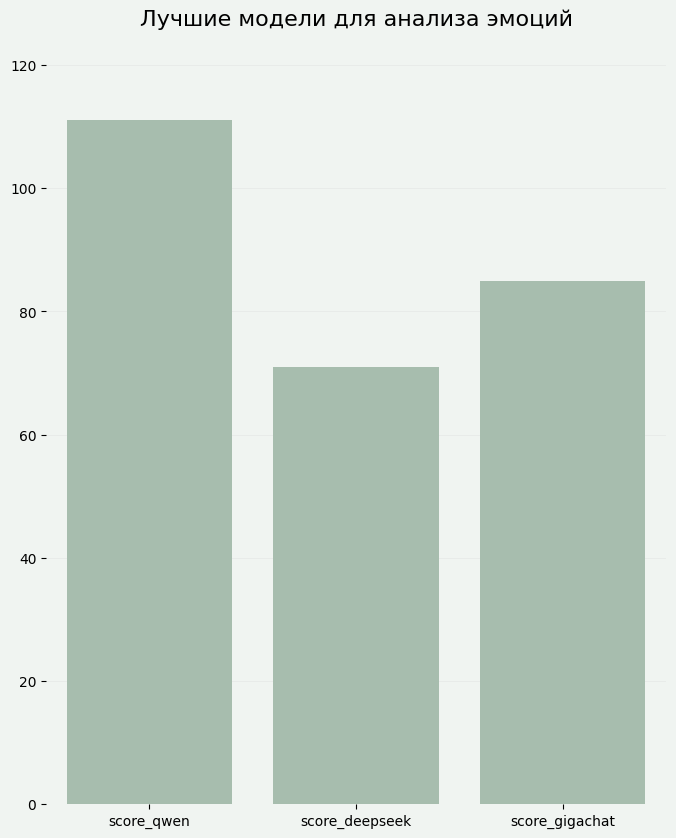

In [82]:
pastel_bar_color = '#a3c1ad'
pastel_background_color = '#f0f4f1'
grid_line_color = 'gray'

plt.rcParams['font.family'] = 'DejaVu Sans'

fig, ax = plt.subplots(figsize=(8, 10))


fig.patch.set_facecolor(pastel_background_color)
ax.set_facecolor(pastel_background_color)

sns.barplot(data, color=pastel_bar_color, ax=ax)

for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_ylim(0, 125)
ax.set_title("Лучшие модели для анализа эмоций", fontsize=16, color='black')
ax.grid(True,
        which='major',
        axis='y',
        linestyle='-',
        linewidth=0.5,
        color=grid_line_color,
        alpha=0.1)

ax.set_axisbelow(True)
plt.show()

Это тест не только на умение выявлять эмоции, но и умение следовать инструкциям